In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Libraries and Filesystem Setup

In [8]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy
from sklearn.preprocessing import normalize

### Import Glove document vectors

In [9]:
gv_matrix = np.load("../../processed_files/gv_matrix.npy", allow_pickle = True)
df_merged = pickle.load(open("../../processed_files/df_merged.pickle", "rb"))

In [10]:
gv_matrix = normalize(gv_matrix, norm = 'l2', axis = 1)

In [11]:
df_merged.head()

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED
0,0-my.com,0-my.com related searches: related searches:,"[mycom, related, searches, related, searches]","[0, -, m, y, ., c, o, m, , r, e, l, a, t, e, ..."
1,00bitz.com,error. page cannot be displayed. please contac...,"[error, page, cannot, displayed, please, conta...","[e, r, r, o, r, ., , p, a, g, e, , c, a, n, ..."
2,01187.com,01187.com is available for purchase! - wwwv1.c...,"[com, vailable, purchase, wwwvcom, welcome, uu...","[0, 1, 1, 8, 7, ., c, o, m, , i, s, , a, v, ..."
3,027.ir,"027.ir - dns4.ir 027.ir hits: 7,267 under cons...","[ir, dnsir, ir, hits, construction, coming, so...","[0, 2, 7, ., i, r, , -, , d, n, s, 4, ., i, ..."
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ..."


In [12]:
df_merged.shape

(12975, 4)

In [13]:
gv_matrix.shape

(12968, 300)

## gv_matrix

In [14]:
num_clusters = 20
algorithm = 'full'

In [15]:
%%time
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0, algorithm=algorithm).fit(gv_matrix)

CPU times: user 32.3 s, sys: 5.26 s, total: 37.6 s
Wall time: 5.7 s


In [16]:
kmeans.labels_

array([13, 17, 10, ...,  1, 10,  1], dtype=int32)

In [17]:
index_cluster = zip(range(len(kmeans.labels_)), kmeans.labels_)
index_cluster_dict = dict(index_cluster)
index_cluster_dict[456]

5

In [18]:
cluster_index = list(zip(kmeans.labels_, range(len(kmeans.labels_))))

In [19]:
cluster_list = dict()
for i in range(num_clusters):
    cluster_list[i] = list(filter(lambda row: row[0] == i, cluster_index))

In [20]:
cluster_list[0]

[(0, 37),
 (0, 78),
 (0, 113),
 (0, 134),
 (0, 137),
 (0, 199),
 (0, 288),
 (0, 290),
 (0, 298),
 (0, 344),
 (0, 419),
 (0, 453),
 (0, 488),
 (0, 565),
 (0, 614),
 (0, 654),
 (0, 664),
 (0, 707),
 (0, 825),
 (0, 828),
 (0, 854),
 (0, 936),
 (0, 984),
 (0, 1005),
 (0, 1015),
 (0, 1018),
 (0, 1031),
 (0, 1063),
 (0, 1149),
 (0, 1233),
 (0, 1311),
 (0, 1340),
 (0, 1517),
 (0, 1550),
 (0, 1571),
 (0, 1597),
 (0, 1622),
 (0, 1650),
 (0, 1969),
 (0, 1971),
 (0, 1998),
 (0, 2011),
 (0, 2049),
 (0, 2142),
 (0, 2226),
 (0, 2389),
 (0, 2413),
 (0, 2461),
 (0, 2531),
 (0, 2533),
 (0, 2566),
 (0, 2616),
 (0, 2712),
 (0, 2801),
 (0, 2849),
 (0, 3126),
 (0, 3128),
 (0, 3160),
 (0, 3164),
 (0, 3179),
 (0, 3184),
 (0, 3264),
 (0, 3268),
 (0, 3290),
 (0, 3316),
 (0, 3461),
 (0, 3469),
 (0, 3577),
 (0, 3582),
 (0, 3617),
 (0, 3662),
 (0, 3728),
 (0, 3757),
 (0, 3791),
 (0, 3796),
 (0, 3808),
 (0, 3858),
 (0, 3866),
 (0, 3886),
 (0, 3907),
 (0, 3922),
 (0, 4060),
 (0, 4161),
 (0, 4171),
 (0, 4218),
 (0, 

In [21]:
print(kmeans.labels_.shape)
print(kmeans.cluster_centers_.shape)

(12968,)
(20, 300)


In [22]:
import statistics

# index is cluster index
def intracluster_similarity(index):
    cluster_centroid = kmeans.cluster_centers_[index]
    dist_list = []
    cluster = cluster_list[index]
    for i in cluster:
        distance = np.linalg.norm(cluster_centroid-gv_matrix[i[1]])
        dist_list.append(distance)
        
    #avg = sum_dist/(len(indices[index])-1)
    avg = np.average(dist_list)

    #variance = statistics.variance(dist_list)
    variance = np.var(dist_list)
    
    return avg, variance

In [23]:
intracluster_similarity(6)

(0.46528077356024305, 0.010974471716999997)

In [24]:
# index is cluster / cluster id
def generate_raw_content_cluster_df(index):
    index_list = cluster_list[index]
    index_list = [x[1] for x in index_list]
    cluster_seed = df_merged.loc[index].to_frame().T
    #cluster_df = df_merged.loc[index_list[1:]]
    cluster_df = df_merged.loc[index_list[1:]]
    combined = pd.concat([cluster_seed, cluster_df])
    combined['cluster'] = index
    return combined

In [25]:
generate_raw_content_cluster_df(4)

,DOMAIN,RAW_CONTENT,RAW_CONTENT_PROCESSED,RAW_CONTENT_PROCESSED_STEMMED,cluster
4,03h.org,february | 2014 | online marketing review sear...,"[february, online, marketing, review, search, ...","[f, e, b, r, u, a, r, y, , |, , 2, 0, 1, 4, ...",4
62,1stdayfresh.com,hennessy vs class winner vader the wildcard dr...,"[hennessy, vs, class, winner, vader, wildcard,...","[h, e, n, n, e, s, s, y, , v, s, , c, l, a, ...",4
112,366526.vip,404 not found 404 not found the requested url ...,"[found, found, requested, url, found, server, ...","[4, 0, 4, , n, o, t, , f, o, u, n, d, , 4, ...",4
139,4gusa.com,4gusa.com related searches: related searches:,"[gusacom, related, searches, related, searches]","[4, g, u, s, a, ., c, o, m, , r, e, l, a, t, ...",4
212,aboutregional.com.au,calls for historic charleyong bridge to be sav...,"[calls, historic, charleyong, bridge, saved, t...","[c, a, l, l, s, , f, o, r, , h, i, s, t, o, ...",4
239,account-receivable-financing.org,account receivables factoring| what makes a fa...,"[account, receivables, factoring, makes, facto...","[a, c, c, o, u, n, t, , r, e, c, e, i, v, a, ...",4
264,acrossboardconsulting.com,our core values – across board consulting the ...,"[core, values, –, across, board, consulting, s...","[o, u, r, , c, o, r, e, , v, a, l, u, e, s, ...",4
267,acstpets.com,"all creatures short and tall - home grooming, ...","[creatures, short, tall, home, grooming, day, ...","[a, l, l, , c, r, e, a, t, u, r, e, s, , s, ...",4
394,ahistoryofnewyork.com,patell and waterman's history of new york | be...,"[patell, watermans, history, new, york, course...","[p, a, t, e, l, l, , a, n, d, , w, a, t, e, ...",4
422,ajaxphotographyclub.com,about us – the ajax photography club toggle na...,"[us, –, ajax, photography, club, toggle, navig...","[a, b, o, u, t, , u, s, , –, , t, h, e, , ...",4


In [26]:
avg_list = []
variance_list = []

for i in range(num_clusters):
    avg, variance = intracluster_similarity(i)
    avg_list.append(avg)
    variance_list.append(variance)
    #print()

([<matplotlib.axis.XTick at 0x1a68ef2978>,
 <a list of 11 Text xticklabel objects>)

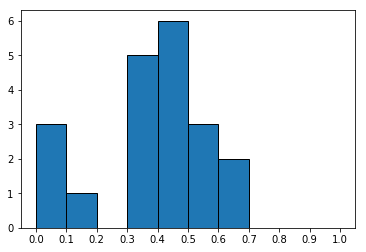

In [27]:
# neighbors = 10
bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.hist(avg_list, bins=bins, edgecolor="k")
plt.xticks(bins)

## Intercluster Similarity

In [28]:
def intercluster_dist():
    indices = range(len(kmeans.cluster_centers_))
    centroid_centroid_distance = {}
    values = []
    for i in indices:
        for j in indices:
            if i < j:
                key = str(i) + "::" + str(j)
                distance = np.linalg.norm(kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j])
                centroid_centroid_distance[key] = distance
                values.append(distance)
    return centroid_centroid_distance, values

## number of clusters = 20

In [29]:
intercluster_distances, values = intercluster_dist()
#print('distances', values)
print('average', np.average(values))

average 0.6749024906407338
